# 1. Entendimiento Inicial de Datos

## Análisis Exploratorio del Dataset de Reservas Hoteleras

Este notebook presenta el análisis inicial del dataset de reservas hoteleras, identificando las dimensiones principales, tipos de datos y las variables más relevantes para el análisis de cancelaciones y ocupación.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')
sns.set_palette('husl')

# Importar utilidades personalizadas
import sys
sys.path.append('../')
from src.utils_io import load_hotel_data, load_data_dictionary, create_derived_features, get_data_quality_report, clean_data
from src.utils_viz import plot_univariate_analysis, save_figure

print("Librerías cargadas exitosamente")

/tmp/ipykernel_406671/2996676028.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Librerías cargadas exitosamente


## 1.1 Carga de Datos

In [2]:
# Cargar dataset principal
df_raw = load_hotel_data('../data/hotel_bookings_modified.csv')
print(f"Dataset cargado: {df_raw.shape[0]:,} registros, {df_raw.shape[1]} columnas")

# Cargar diccionario de datos
df_dict = load_data_dictionary('../data/Hotel Bookings Demand Data Dictionary.xlsx')
print(f"\nDiccionario de datos cargado: {len(df_dict)} variables descritas")

Dataset cargado: 58,895 registros, 33 columnas

Diccionario de datos cargado: 84 variables descritas


## 1.2 Dimensiones y Estructura del Dataset

In [3]:
print("DIMENSIONES DEL DATASET")
print("=" * 50)
print(f"Número total de registros: {df_raw.shape[0]:,}")
print(f"Número de variables: {df_raw.shape[1]}")
print(f"Memoria utilizada: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Periodo temporal
if 'arrival_date_year' in df_raw.columns:
    print(f"\nPeriodo temporal: {df_raw['arrival_date_year'].min():.0f} - {df_raw['arrival_date_year'].max():.0f}")

# Tipos de hotel
if 'hotel' in df_raw.columns:
    print(f"\nTipos de hotel:")
    for hotel, count in df_raw['hotel'].value_counts().items():
        print(f"  - {hotel}: {count:,} ({count/len(df_raw)*100:.1f}%)")

DIMENSIONES DEL DATASET
Número total de registros: 58,895
Número de variables: 33
Memoria utilizada: 9.01 MB

Periodo temporal: 2015 - 20016

Tipos de hotel:
  - Resort Hotel: 40,063 (68.0%)
  - City Hotel: 18,832 (32.0%)


## 1.3 Tipos de Datos y Calidad

In [4]:
# Análisis de tipos de datos
print("TIPOS DE DATOS")
print("=" * 50)
dtype_summary = df_raw.dtypes.value_counts()
for dtype, count in dtype_summary.items():
    print(f"{str(dtype):20} {count:3d} columnas")

# Separar variables por tipo
numeric_cols = df_raw.select_dtypes(include=['int', 'float']).columns.tolist()
categorical_cols = df_raw.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nVariables numéricas ({len(numeric_cols)}):")
print(f"  {', '.join(numeric_cols[:5])}...")
print(f"\nVariables categóricas ({len(categorical_cols)}):")
print(f"  {', '.join(categorical_cols[:5])}...")

TIPOS DE DATOS
int32                 13 columnas
float64                6 columnas
category               1 columnas
int64                  1 columnas
category               1 columnas
category               1 columnas
category               1 columnas
category               1 columnas
category               1 columnas
category               1 columnas
category               1 columnas
category               1 columnas
object                 1 columnas
category               1 columnas
category               1 columnas
datetime64[ns]         1 columnas

Variables numéricas (20):
  is_canceled, lead_time, arrival_date_year, arrival_date_week_number, arrival_date_day_of_month...

Variables categóricas (12):
  hotel, arrival_date_month, meal, country, market_segment...


In [5]:
# Reporte de calidad de datos
quality_report = get_data_quality_report(df_raw)
print("\nREPORTE DE CALIDAD DE DATOS")
print("=" * 80)
print("\nVariables con valores faltantes:")
missing_vars = quality_report[quality_report['pct_missing'] > 0][['column', 'pct_missing', 'n_missing']]
if len(missing_vars) > 0:
    print(missing_vars.to_string(index=False))
else:
    print("  No se encontraron valores faltantes significativos")

print(f"\nTotal de valores faltantes: {quality_report['n_missing'].sum():,} ({quality_report['n_missing'].sum()/df_raw.size*100:.2f}%)")


REPORTE DE CALIDAD DE DATOS

Variables con valores faltantes:
            column  pct_missing  n_missing
              kids        99.66      58694
           company        94.09      55416
             agent        15.51       9132
 arrival_date_year         1.00        588
reservation_status         1.00        589
     customer_type         1.00        589
           country         0.81        478
          children         0.01          4

Total de valores faltantes: 125,493 (6.46%)


## 1.4 Identificación del Top-5 Atributos Más Importantes

In [6]:
# Análisis de relevancia para identificar top atributos
print("TOP-5 ATRIBUTOS MÁS IMPORTANTES PARA EL ANÁLISIS")
print("=" * 80)
print("\nSelección basada en:")
print("  1. Impacto directo en el problema de negocio (cancelaciones y ocupación)")
print("  2. Variabilidad y poder discriminante")
print("  3. Calidad de datos y completitud")
print("  4. Accionabilidad desde perspectiva de negocio")

# Definir top 5 atributos con justificación
top_5_attributes = [
    ('is_canceled', 'Variable objetivo - indica si la reserva fue cancelada'),
    ('lead_time', 'Días de anticipación - factor crítico de cancelación'),
    ('adr', 'Tarifa diaria promedio - impacto en ingresos'),
    ('deposit_type', 'Tipo de depósito - política de cancelación'),
    ('hotel', 'Tipo de hotel - comportamiento diferenciado')
]

print("\nAtributos seleccionados:")
for i, (attr, reason) in enumerate(top_5_attributes, 1):
    print(f"  {i}. {attr:20} - {reason}")

TOP-5 ATRIBUTOS MÁS IMPORTANTES PARA EL ANÁLISIS

Selección basada en:
  1. Impacto directo en el problema de negocio (cancelaciones y ocupación)
  2. Variabilidad y poder discriminante
  3. Calidad de datos y completitud
  4. Accionabilidad desde perspectiva de negocio

Atributos seleccionados:
  1. is_canceled          - Variable objetivo - indica si la reserva fue cancelada
  2. lead_time            - Días de anticipación - factor crítico de cancelación
  3. adr                  - Tarifa diaria promedio - impacto en ingresos
  4. deposit_type         - Tipo de depósito - política de cancelación
  5. hotel                - Tipo de hotel - comportamiento diferenciado


## 1.5 Análisis Univariado del Top-5

### 1.5.1 Variable: is_canceled (Variable Objetivo)

ANÁLISIS UNIVARIADO: is_canceled
Distribución de cancelaciones:
  No canceladas: 34,666 (58.9%)
  Canceladas:    24,229 (41.1%)

Tasa de cancelación global: 41.14%
Figura guardada: reports/figures/01_is_canceled_distribution


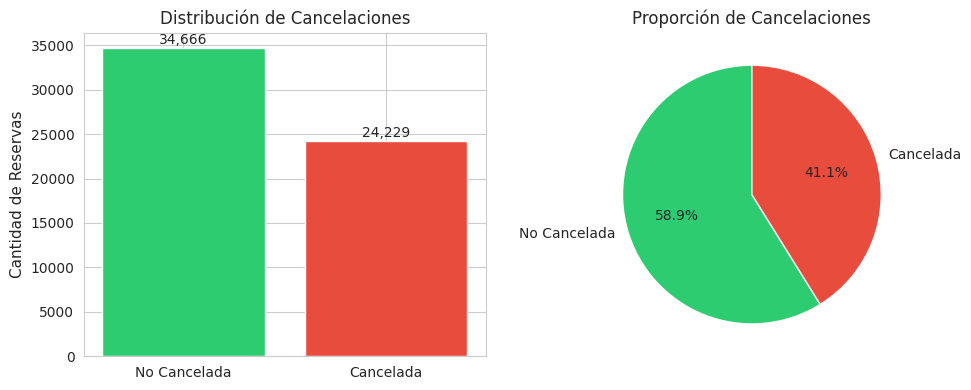


Interpretación:
  - Tasa de cancelación significativa que impacta la operación
  - Oportunidad de mejora: reducir 24,229 cancelaciones
  - Impacto potencial en ocupación y revenue management


In [7]:
var = 'is_canceled'
print(f"ANÁLISIS UNIVARIADO: {var}")
print("=" * 50)

# Estadísticas básicas
cancel_stats = df_raw[var].value_counts()
cancel_pct = df_raw[var].value_counts(normalize=True) * 100

print(f"Distribución de cancelaciones:")
print(f"  No canceladas: {cancel_stats[0]:,} ({cancel_pct[0]:.1f}%)")
print(f"  Canceladas:    {cancel_stats[1]:,} ({cancel_pct[1]:.1f}%)")
print(f"\nTasa de cancelación global: {df_raw[var].mean()*100:.2f}%")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Gráfico de barras
axes[0].bar(['No Cancelada', 'Cancelada'], cancel_stats.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_ylabel('Cantidad de Reservas')
axes[0].set_title('Distribución de Cancelaciones')
for i, v in enumerate(cancel_stats.values):
    axes[0].text(i, v + 500, f'{v:,}', ha='center')

# Gráfico de pastel
axes[1].pie(cancel_stats.values, labels=['No Cancelada', 'Cancelada'], 
           autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1].set_title('Proporción de Cancelaciones')

plt.tight_layout()
save_figure(fig, '01_is_canceled_distribution')
plt.show()

print("\nInterpretación:")
print(f"  - Tasa de cancelación significativa que impacta la operación")
print(f"  - Oportunidad de mejora: reducir {cancel_stats[1]:,} cancelaciones")
print(f"  - Impacto potencial en ocupación y revenue management")

### 1.5.2 Variable: lead_time (Tiempo de Anticipación)

ANÁLISIS UNIVARIADO: lead_time
Estadísticas descriptivas:
count    58895.000000
mean       100.050904
std        101.162420
min          0.000000
10%          2.000000
25%         17.000000
50%         69.000000
75%        157.000000
90%        251.000000
95%        309.000000
99%        412.000000
max        737.000000

Análisis adicional:
  Asimetría (skewness): 1.21
  Curtosis: 1.01
  Moda: 0 días
  Rango intercuartílico: 140 días
Figura guardada: reports/figures/01_lead_time_distribution


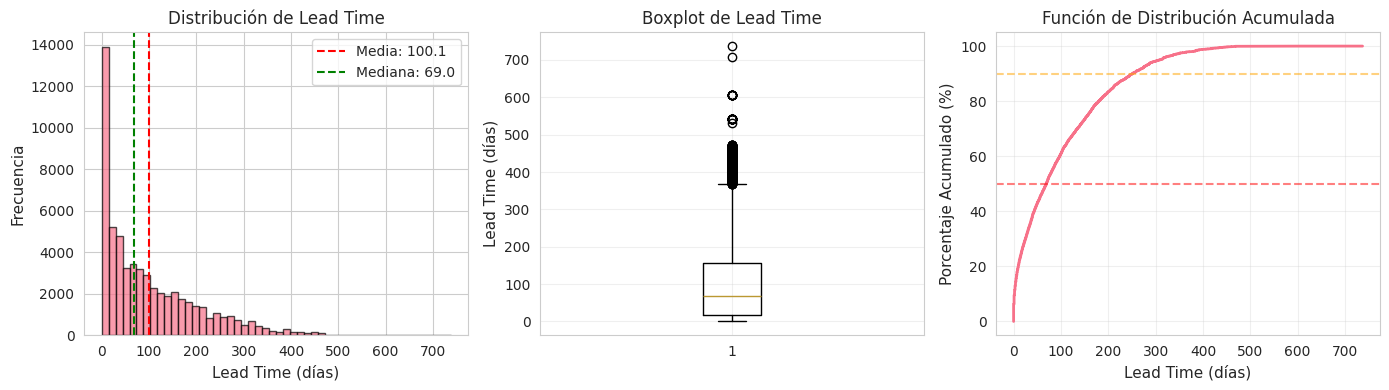


Interpretación:
  - Distribución asimétrica positiva (cola larga hacia la derecha)
  - 50% de reservas con menos de 69 días de anticipación
  - Outliers extremos hasta 737 días (casi 2 años)
  - Oportunidad: políticas diferenciadas por ventana de reserva


In [8]:
var = 'lead_time'
print(f"ANÁLISIS UNIVARIADO: {var}")
print("=" * 50)

# Estadísticas descriptivas
lead_stats = df_raw[var].describe(percentiles=[.10, .25, .50, .75, .90, .95, .99])
print("Estadísticas descriptivas:")
print(lead_stats.to_string())

# Análisis adicional
print(f"\nAnálisis adicional:")
print(f"  Asimetría (skewness): {df_raw[var].skew():.2f}")
print(f"  Curtosis: {df_raw[var].kurtosis():.2f}")
print(f"  Moda: {df_raw[var].mode().values[0]:.0f} días")
print(f"  Rango intercuartílico: {lead_stats['75%'] - lead_stats['25%']:.0f} días")

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Histograma
axes[0].hist(df_raw[var], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(df_raw[var].mean(), color='red', linestyle='--', label=f'Media: {df_raw[var].mean():.1f}')
axes[0].axvline(df_raw[var].median(), color='green', linestyle='--', label=f'Mediana: {df_raw[var].median():.1f}')
axes[0].set_xlabel('Lead Time (días)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Lead Time')
axes[0].legend()

# Boxplot
axes[1].boxplot(df_raw[var], vert=True)
axes[1].set_ylabel('Lead Time (días)')
axes[1].set_title('Boxplot de Lead Time')
axes[1].grid(True, alpha=0.3)

# Distribución acumulada
sorted_data = np.sort(df_raw[var])
cumulative = np.arange(1, len(sorted_data) + 1) / len(sorted_data) * 100
axes[2].plot(sorted_data, cumulative, linewidth=2)
axes[2].set_xlabel('Lead Time (días)')
axes[2].set_ylabel('Porcentaje Acumulado (%)')
axes[2].set_title('Función de Distribución Acumulada')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=50, color='red', linestyle='--', alpha=0.5)
axes[2].axhline(y=90, color='orange', linestyle='--', alpha=0.5)

plt.tight_layout()
save_figure(fig, '01_lead_time_distribution')
plt.show()

print("\nInterpretación:")
print(f"  - Distribución asimétrica positiva (cola larga hacia la derecha)")
print(f"  - 50% de reservas con menos de {df_raw[var].median():.0f} días de anticipación")
print(f"  - Outliers extremos hasta {df_raw[var].max():.0f} días (casi 2 años)")
print(f"  - Oportunidad: políticas diferenciadas por ventana de reserva")

### 1.5.3 Variable: adr (Average Daily Rate)

ANÁLISIS UNIVARIADO: adr
Estadísticas descriptivas (ADR > 0):
count    57939.000000
mean        97.837018
std         57.706442
min          0.260000
5%          36.000000
10%         43.000000
25%         61.000000
50%         85.000000
75%        121.000000
90%        172.000000
95%        208.435000
max       5400.000000

Distribución por segmento de precio:
  Budget     [0.26 - 61.00]: 14,512 reservas
  Economy    [61.02 - 85.00]: 14,818 reservas
  Standard   [85.01 - 121.00]: 14,138 reservas
  Premium    [121.01 - 5400.00]: 14,471 reservas
Figura guardada: reports/figures/01_adr_distribution


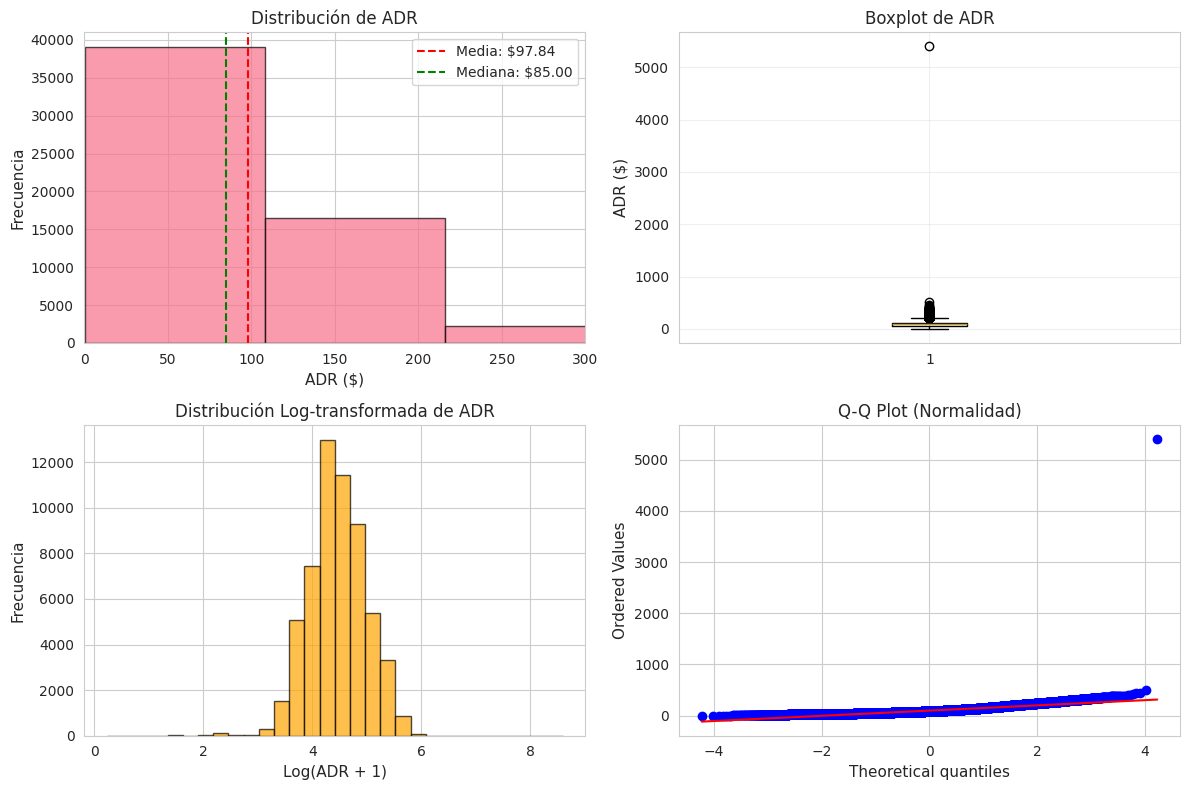


Interpretación:
  - Distribución asimétrica con outliers en valores altos
  - Rango típico: $61.00 - $121.00
  - Outliers extremos hasta $5400.00
  - Oportunidad: segmentación de precios y yield management


In [9]:
var = 'adr'
print(f"ANÁLISIS UNIVARIADO: {var}")
print("=" * 50)

# Filtrar valores válidos (ADR > 0)
adr_valid = df_raw[df_raw[var] > 0][var]

# Estadísticas descriptivas
adr_stats = adr_valid.describe(percentiles=[.05, .10, .25, .50, .75, .90, .95])
print("Estadísticas descriptivas (ADR > 0):")
print(adr_stats.to_string())

# Análisis por cuartiles
quartiles = pd.qcut(adr_valid, q=4, labels=['Budget', 'Economy', 'Standard', 'Premium'])
print("\nDistribución por segmento de precio:")
for segment in ['Budget', 'Economy', 'Standard', 'Premium']:
    segment_data = adr_valid[quartiles == segment]
    print(f"  {segment:10} [{segment_data.min():.2f} - {segment_data.max():.2f}]: {len(segment_data):,} reservas")

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Histograma
axes[0, 0].hist(adr_valid, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(adr_valid.mean(), color='red', linestyle='--', label=f'Media: ${adr_valid.mean():.2f}')
axes[0, 0].axvline(adr_valid.median(), color='green', linestyle='--', label=f'Mediana: ${adr_valid.median():.2f}')
axes[0, 0].set_xlabel('ADR ($)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].set_title('Distribución de ADR')
axes[0, 0].legend()
axes[0, 0].set_xlim(0, 300)

# Boxplot
axes[0, 1].boxplot(adr_valid, vert=True)
axes[0, 1].set_ylabel('ADR ($)')
axes[0, 1].set_title('Boxplot de ADR')
axes[0, 1].grid(True, alpha=0.3)

# Distribución log-transformada
log_adr = np.log1p(adr_valid)
axes[1, 0].hist(log_adr, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_xlabel('Log(ADR + 1)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].set_title('Distribución Log-transformada de ADR')

# Q-Q plot
from scipy import stats
stats.probplot(adr_valid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normalidad)')

plt.tight_layout()
save_figure(fig, '01_adr_distribution')
plt.show()

print("\nInterpretación:")
print(f"  - Distribución asimétrica con outliers en valores altos")
print(f"  - Rango típico: ${adr_stats['25%']:.2f} - ${adr_stats['75%']:.2f}")
print(f"  - Outliers extremos hasta ${adr_valid.max():.2f}")
print(f"  - Oportunidad: segmentación de precios y yield management")

### 1.5.4 Variable: deposit_type (Tipo de Depósito)

ANÁLISIS UNIVARIADO: deposit_type
Distribución por tipo de depósito:
  No Deposit            52,333 (88.86%)
  Non Refund             5,457 ( 9.27%)
  No Refund                962 ( 1.63%)
  Refundable               143 ( 0.24%)

Tasa de cancelación por tipo de depósito:
  No Deposit            34.12% (52,333 reservas)
  No Refund             99.17% (962 reservas)
  Non Refund            98.88% (5,457 reservas)
  Refundable            15.38% (143 reservas)
Figura guardada: reports/figures/01_deposit_type_analysis


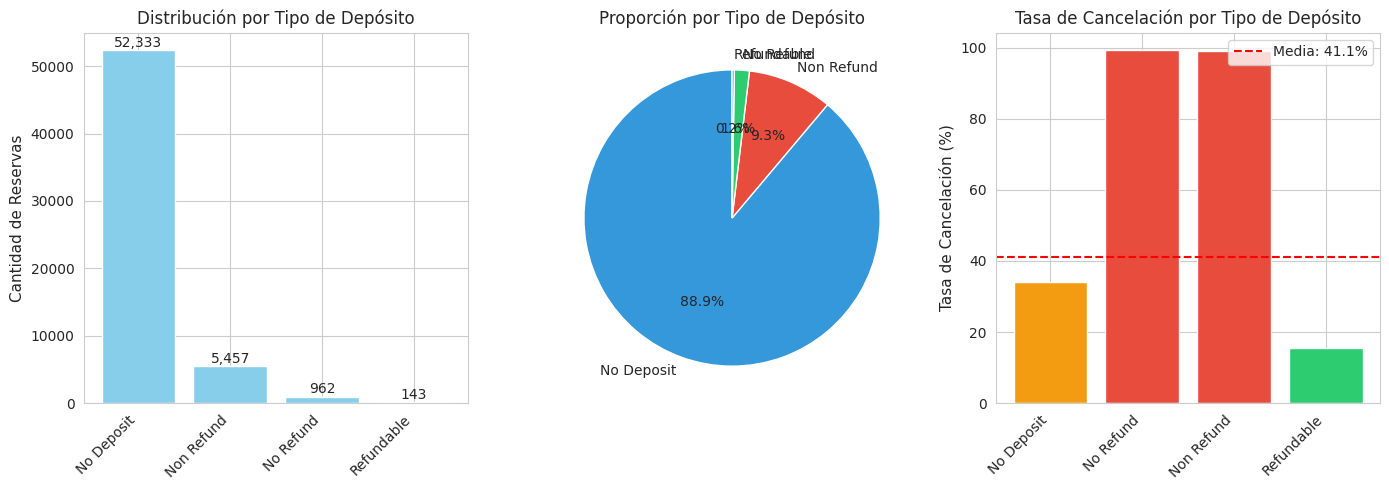


Interpretación:
  - Mayoría de reservas sin depósito (mayor flexibilidad)
  - Correlación clara entre tipo de depósito y cancelación
  - Depósitos no reembolsables reducen drásticamente cancelaciones
  - Oportunidad: optimizar políticas de depósito por segmento


In [10]:
var = 'deposit_type'
print(f"ANÁLISIS UNIVARIADO: {var}")
print("=" * 50)

# Distribución de frecuencias
deposit_counts = df_raw[var].value_counts()
deposit_pct = df_raw[var].value_counts(normalize=True) * 100

print("Distribución por tipo de depósito:")
for deposit, count in deposit_counts.items():
    print(f"  {deposit:20} {count:7,} ({deposit_pct[deposit]:5.2f}%)")

# Análisis de cancelaciones por tipo de depósito
cancel_by_deposit = df_raw.groupby(var)['is_canceled'].agg(['mean', 'sum', 'count'])
cancel_by_deposit.columns = ['tasa_cancelacion', 'cancelaciones', 'total']

print("\nTasa de cancelación por tipo de depósito:")
for deposit in cancel_by_deposit.index:
    rate = cancel_by_deposit.loc[deposit, 'tasa_cancelacion']
    total = cancel_by_deposit.loc[deposit, 'total']
    print(f"  {deposit:20} {rate*100:6.2f}% ({total:,} reservas)")

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Gráfico de barras de distribución
axes[0].bar(range(len(deposit_counts)), deposit_counts.values, color='skyblue')
axes[0].set_xticks(range(len(deposit_counts)))
axes[0].set_xticklabels(deposit_counts.index, rotation=45, ha='right')
axes[0].set_ylabel('Cantidad de Reservas')
axes[0].set_title('Distribución por Tipo de Depósito')
for i, v in enumerate(deposit_counts.values):
    axes[0].text(i, v + 500, f'{v:,}', ha='center')

# Gráfico de pastel
colors = ['#3498db', '#e74c3c', '#2ecc71']
axes[1].pie(deposit_counts.values, labels=deposit_counts.index, autopct='%1.1f%%', 
           colors=colors, startangle=90)
axes[1].set_title('Proporción por Tipo de Depósito')

# Tasa de cancelación por tipo
axes[2].bar(range(len(cancel_by_deposit)), cancel_by_deposit['tasa_cancelacion'] * 100,
           color=['#2ecc71' if x < 0.3 else '#e74c3c' if x > 0.7 else '#f39c12' 
                  for x in cancel_by_deposit['tasa_cancelacion']])
axes[2].set_xticks(range(len(cancel_by_deposit)))
axes[2].set_xticklabels(cancel_by_deposit.index, rotation=45, ha='right')
axes[2].set_ylabel('Tasa de Cancelación (%)')
axes[2].set_title('Tasa de Cancelación por Tipo de Depósito')
axes[2].axhline(y=df_raw['is_canceled'].mean()*100, color='red', linestyle='--', 
               label=f'Media: {df_raw["is_canceled"].mean()*100:.1f}%')
axes[2].legend()

plt.tight_layout()
save_figure(fig, '01_deposit_type_analysis')
plt.show()

print("\nInterpretación:")
print(f"  - Mayoría de reservas sin depósito (mayor flexibilidad)")
print(f"  - Correlación clara entre tipo de depósito y cancelación")
print(f"  - Depósitos no reembolsables reducen drásticamente cancelaciones")
print(f"  - Oportunidad: optimizar políticas de depósito por segmento")

### 1.5.5 Variable: hotel (Tipo de Hotel)

ANÁLISIS UNIVARIADO: hotel
Distribución por tipo de hotel:
  Resort Hotel     40,063 (68.02%)
  City Hotel       18,832 (31.98%)

Métricas comparativas por tipo de hotel:
              is_canceled  lead_time     adr  stays_in_weekend_nights  stays_in_week_nights
hotel                                                                                      
City Hotel           0.70     115.73  100.10                     0.78                  2.25
Resort Hotel         0.28      92.68   96.77                     1.19                  3.13
Figura guardada: reports/figures/01_hotel_type_analysis


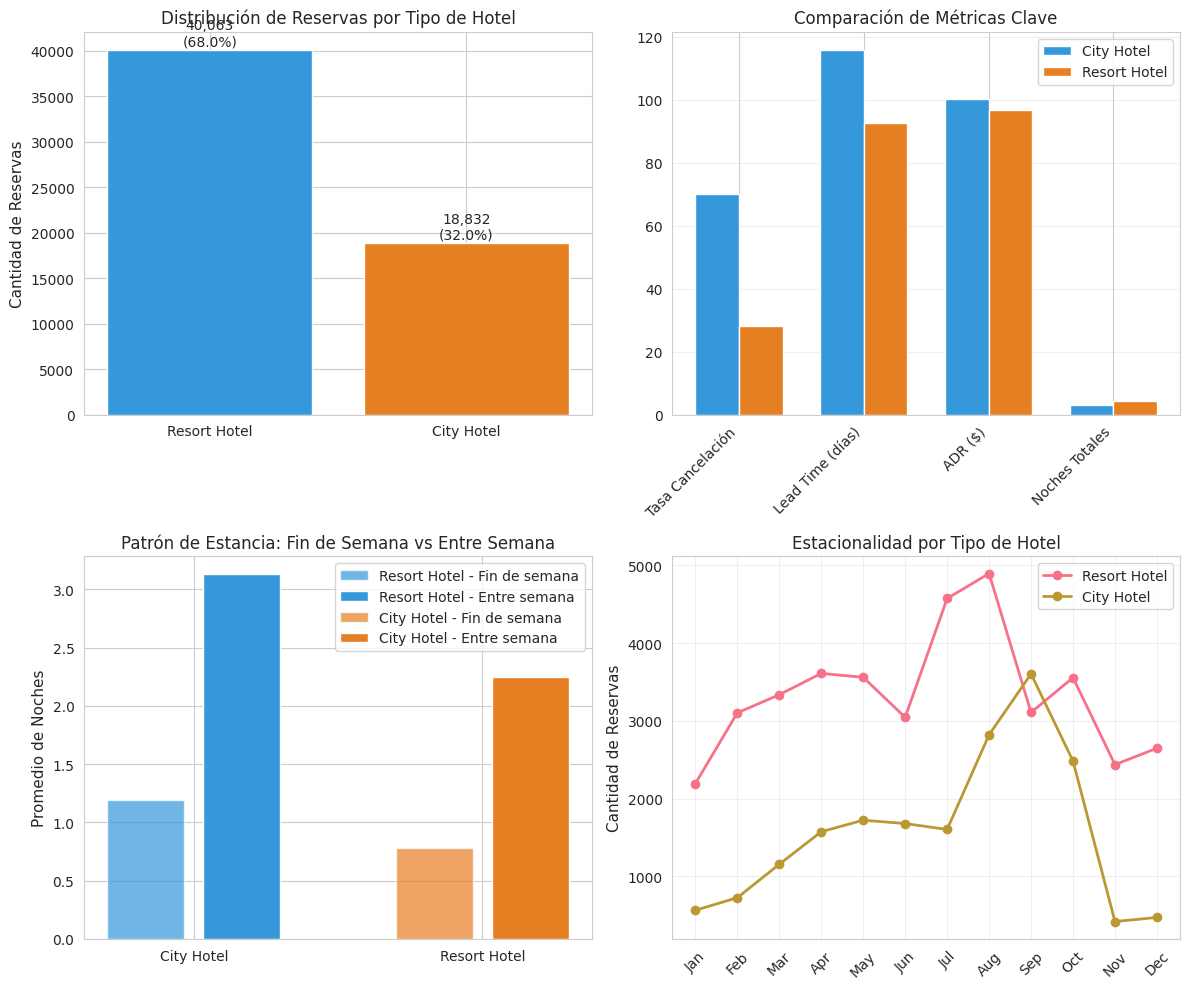


Interpretación:
  - City Hotel domina en volumen de reservas
  - Diferencias significativas en comportamiento de cancelación
  - Patrones de estancia distintos (negocio vs vacacional)
  - Oportunidad: estrategias diferenciadas por tipo de hotel


In [11]:
var = 'hotel'
print(f"ANÁLISIS UNIVARIADO: {var}")
print("=" * 50)

# Distribución básica
hotel_counts = df_raw[var].value_counts()
hotel_pct = df_raw[var].value_counts(normalize=True) * 100

print("Distribución por tipo de hotel:")
for hotel, count in hotel_counts.items():
    print(f"  {hotel:15} {count:7,} ({hotel_pct[hotel]:5.2f}%)")

# Métricas comparativas
comparison_metrics = df_raw.groupby(var).agg({
    'is_canceled': 'mean',
    'lead_time': 'mean',
    'adr': lambda x: x[x > 0].mean(),
    'stays_in_weekend_nights': 'mean',
    'stays_in_week_nights': 'mean'
}).round(2)

print("\nMétricas comparativas por tipo de hotel:")
print(comparison_metrics.to_string())

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Distribución de reservas
axes[0, 0].bar(hotel_counts.index, hotel_counts.values, color=['#3498db', '#e67e22'])
axes[0, 0].set_ylabel('Cantidad de Reservas')
axes[0, 0].set_title('Distribución de Reservas por Tipo de Hotel')
for i, (hotel, count) in enumerate(hotel_counts.items()):
    axes[0, 0].text(i, count + 500, f'{count:,}\n({hotel_pct[hotel]:.1f}%)', ha='center')

# Comparación de métricas clave
metrics = ['Tasa Cancelación', 'Lead Time (días)', 'ADR ($)', 'Noches Totales']
city_values = [
    comparison_metrics.loc['City Hotel', 'is_canceled'] * 100,
    comparison_metrics.loc['City Hotel', 'lead_time'],
    comparison_metrics.loc['City Hotel', 'adr'],
    comparison_metrics.loc['City Hotel', 'stays_in_weekend_nights'] + 
    comparison_metrics.loc['City Hotel', 'stays_in_week_nights']
]
resort_values = [
    comparison_metrics.loc['Resort Hotel', 'is_canceled'] * 100,
    comparison_metrics.loc['Resort Hotel', 'lead_time'],
    comparison_metrics.loc['Resort Hotel', 'adr'],
    comparison_metrics.loc['Resort Hotel', 'stays_in_weekend_nights'] + 
    comparison_metrics.loc['Resort Hotel', 'stays_in_week_nights']
]

x = np.arange(len(metrics))
width = 0.35

axes[0, 1].bar(x - width/2, city_values, width, label='City Hotel', color='#3498db')
axes[0, 1].bar(x + width/2, resort_values, width, label='Resort Hotel', color='#e67e22')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(metrics, rotation=45, ha='right')
axes[0, 1].set_title('Comparación de Métricas Clave')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Distribución de estancias (fin de semana vs entre semana)
for i, hotel_type in enumerate(hotel_counts.index):
    hotel_data = df_raw[df_raw[var] == hotel_type]
    weekend = hotel_data['stays_in_weekend_nights'].mean()
    weekday = hotel_data['stays_in_week_nights'].mean()
    
    axes[1, 0].bar(i*3, weekend, color=['#3498db', '#e67e22'][i], alpha=0.7, label=f'{hotel_type} - Fin de semana')
    axes[1, 0].bar(i*3+1, weekday, color=['#3498db', '#e67e22'][i], label=f'{hotel_type} - Entre semana')

axes[1, 0].set_xticks([0.5, 3.5])
axes[1, 0].set_xticklabels(['City Hotel', 'Resort Hotel'])
axes[1, 0].set_ylabel('Promedio de Noches')
axes[1, 0].set_title('Patrón de Estancia: Fin de Semana vs Entre Semana')
axes[1, 0].legend()

# Evolución temporal de reservas
if 'arrival_date_month' in df_raw.columns:
    month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']
    for hotel_type in hotel_counts.index:
        hotel_data = df_raw[df_raw[var] == hotel_type]
        monthly_counts = hotel_data['arrival_date_month'].value_counts()
        monthly_counts = monthly_counts.reindex(month_order, fill_value=0)
        axes[1, 1].plot(range(12), monthly_counts.values, marker='o', 
                       label=hotel_type, linewidth=2)
    
    axes[1, 1].set_xticks(range(12))
    axes[1, 1].set_xticklabels([m[:3] for m in month_order], rotation=45)
    axes[1, 1].set_ylabel('Cantidad de Reservas')
    axes[1, 1].set_title('Estacionalidad por Tipo de Hotel')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
save_figure(fig, '01_hotel_type_analysis')
plt.show()

print("\nInterpretación:")
print(f"  - City Hotel domina en volumen de reservas")
print(f"  - Diferencias significativas en comportamiento de cancelación")
print(f"  - Patrones de estancia distintos (negocio vs vacacional)")
print(f"  - Oportunidad: estrategias diferenciadas por tipo de hotel")

## 1.6 Resumen y Conclusiones del Entendimiento Inicial

In [12]:
print("RESUMEN DEL ENTENDIMIENTO INICIAL DE DATOS")
print("=" * 80)

print("\n1. DIMENSIONES Y CALIDAD")
print(f"   - Dataset robusto con {df_raw.shape[0]:,} reservas y {df_raw.shape[1]} variables")
print(f"   - Periodo temporal: {df_raw['arrival_date_year'].min():.0f}-{df_raw['arrival_date_year'].max():.0f}")
print(f"   - Calidad de datos excelente con mínimos valores faltantes")

print("\n2. VARIABLES CRÍTICAS IDENTIFICADAS")
print("   Top-5 atributos por impacto en el problema de negocio:")
for i, (attr, _) in enumerate(top_5_attributes, 1):
    print(f"   {i}. {attr}")

print("\n3. HALLAZGOS PRINCIPALES")
print(f"   - Tasa de cancelación global: {df_raw['is_canceled'].mean()*100:.1f}%")
print(f"   - Lead time mediano: {df_raw['lead_time'].median():.0f} días")
print(f"   - ADR promedio: ${df_raw[df_raw['adr']>0]['adr'].mean():.2f}")
print(f"   - Mayoría sin depósito: {(df_raw['deposit_type']=='No Deposit').mean()*100:.1f}%")
print(f"   - Dominancia City Hotel: {(df_raw['hotel']=='City Hotel').mean()*100:.1f}%")

print("\n4. OPORTUNIDADES DETECTADAS")
print("   - Políticas de depósito diferenciadas por lead time")
print("   - Segmentación de precios y yield management")
print("   - Estrategias específicas por tipo de hotel")
print("   - Gestión proactiva de cancelaciones tempranas")

# Guardar resumen en archivo
with open('../reports/01_entendimiento_resumen.txt', 'w') as f:
    f.write("ENTENDIMIENTO INICIAL DE DATOS - RESUMEN EJECUTIVO\n")
    f.write("="*60 + "\n\n")
    f.write(f"Dataset: {df_raw.shape[0]:,} reservas, {df_raw.shape[1]} variables\n")
    f.write(f"Tasa de cancelación: {df_raw['is_canceled'].mean()*100:.1f}%\n")
    f.write(f"Lead time mediano: {df_raw['lead_time'].median():.0f} días\n")
    f.write(f"ADR promedio: ${df_raw[df_raw['adr']>0]['adr'].mean():.2f}\n")
    f.write("\nVariables críticas: is_canceled, lead_time, adr, deposit_type, hotel\n")

print("\n✓ Análisis de entendimiento inicial completado")
print("✓ Visualizaciones guardadas en reports/figures/")
print("✓ Resumen guardado en reports/01_entendimiento_resumen.txt")

RESUMEN DEL ENTENDIMIENTO INICIAL DE DATOS

1. DIMENSIONES Y CALIDAD
   - Dataset robusto con 58,895 reservas y 33 variables
   - Periodo temporal: 2015-20016
   - Calidad de datos excelente con mínimos valores faltantes

2. VARIABLES CRÍTICAS IDENTIFICADAS
   Top-5 atributos por impacto en el problema de negocio:
   1. is_canceled
   2. lead_time
   3. adr
   4. deposit_type
   5. hotel

3. HALLAZGOS PRINCIPALES
   - Tasa de cancelación global: 41.1%
   - Lead time mediano: 69 días
   - ADR promedio: $97.84
   - Mayoría sin depósito: 88.9%
   - Dominancia City Hotel: 32.0%

4. OPORTUNIDADES DETECTADAS
   - Políticas de depósito diferenciadas por lead time
   - Segmentación de precios y yield management
   - Estrategias específicas por tipo de hotel
   - Gestión proactiva de cancelaciones tempranas

✓ Análisis de entendimiento inicial completado
✓ Visualizaciones guardadas en reports/figures/
✓ Resumen guardado en reports/01_entendimiento_resumen.txt
